# Sponsorship models

Consider senate number 115, this notebook aims to predict votes profile for a bill using the sponsors' votes information.

Any other information on each senator can be encoded on a similarity graph.

In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import ast
from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline 
%load_ext autoreload
%autoreload

from lib import models_alt, graph, coarsening, utils

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
VOTES_115 = '../data/all-votes/votes_115.csv'
BILLS_115 = '../data/bills_115.csv'
ADJACENCY = '../data/adjacency.csv'

In [3]:
all_bills = pd.read_csv(BILLS_115)
votes_115 = pd.read_csv(VOTES_115)
bills_sen = all_bills[all_bills.sponsor_title=='Sen.'] # bills sponsored by senators
N_BILLS_SEN = bills_sen.shape[0]

In [4]:
members_aux = pd.DataFrame(list(votes_115['member_id'].unique())).rename(columns={0: 'member_id'})
members = members_aux.merge(votes_115.drop_duplicates(subset = 'member_id')[['member_id', 'party']], how='left').sort_values(['party', 'member_id'])
N_SENATORS = len(members)

In [5]:
for i,j in enumerate(bills_sen.cosponsors_sen):
    bills_sen.cosponsors_sen.iloc[i] = ast.literal_eval(j)

In [6]:
bills_sen.head()

,Unnamed: 0,bill_api_uri,date,democrats_no,democrats_yes,independent_no,independent_yes,month,republican_no,republican_yes,...,sponsor_id,sponsor_party,sponsor_title,result_ok,nb_cosponsors_R,nb_cosponsors_D,nb_cosponsors_I,cosponsors_sen,cosponsors_rep,cosponsors_del
1,1,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,16,30,1,1,1,0,50,...,M000303,R,Sen.,passed,0,0,0,[],[],[]
2,3,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,0,45,0,2,1,49,2,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
3,4,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,45,0,2,0,1,0,51,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
4,5,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,0,45,0,2,1,49,2,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
5,6,https://api.propublica.org/congress/v1/115/bil...,2017-01-11,44,1,2,0,1,0,51,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]


Create binary matrices indicating sponsorship (and cosponsorship):

In [7]:
S = np.zeros((N_BILLS_SEN, N_SENATORS))
for i, j in enumerate(bills_sen.cosponsors_sen):
    S[i, list(members['member_id']).index(bills_sen.sponsor_id.iloc[i])] = 1

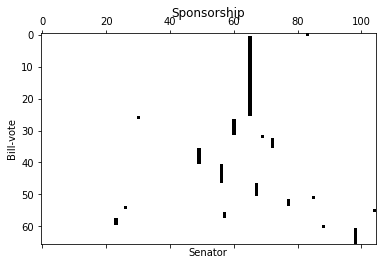

In [8]:
plt.spy(S)
plt.title('Sponsorship')
plt.xlabel('Senator')
plt.ylabel('Bill-vote');

In [9]:
CS = np.zeros((N_BILLS_SEN, N_SENATORS))
for i, j in enumerate(bills_sen.cosponsors_sen):
    for k, l in enumerate(bills_sen.cosponsors_sen.iloc[i]):
        CS[i, list(members['member_id']).index(bills_sen.cosponsors_sen.iloc[i][k])] = 1

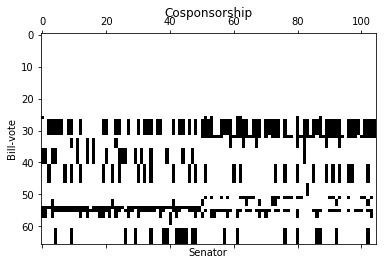

In [10]:
plt.spy(CS)
plt.title('Cosponsorship')
plt.xlabel('Senator')
plt.ylabel('Bill-vote');

In [11]:
Z = S + CS # sponsorship mask

In [12]:
def numeric_votes(x):
    if x == 'Yes':
        return 1
    elif x == 'Not Voting' or pd.isnull(x):
        return 2 # we can put np.nan and then fill with the median or mean, whatever for now
    else:
        return 0

Get all votes for each bill-vote:

In [13]:
Y=np.zeros((N_BILLS_SEN, N_SENATORS))

for i, l in enumerate(list(bills_sen.vote_uri)):
    votes = (members.merge(votes_115[votes_115.vote_uri == l], how='left'))
    feature = votes.vote_position.apply(numeric_votes).values
    Y[i] = feature

In [14]:
Y.shape

(66, 105)

Use as feature vector the voting profile for each senator:

In [15]:
X = -1*np.ones((N_BILLS_SEN, N_SENATORS))
X[Z==1]=Y[Z==1]

In [16]:
X.shape

(66, 105)

In [17]:
n = X.shape[0]
d = X.shape[1]

print('n = {}\nd = {}'.format(n, d))

n = 66
d = 105


In [18]:
n_train = n//2
n_val = n//10

perm_idx = np.random.permutation(n)
X_train = X[perm_idx[:n_train]]
X_val = X[perm_idx[n_train:n_train+n_val]]
X_test = X[perm_idx[n_train+n_val:]]

y_train = Y[perm_idx[:n_train]]
y_val = Y[perm_idx[n_train:n_train+n_val]]
y_test = Y[perm_idx[n_train+n_val:]]


In [19]:
# adj = sparse.csr_matrix(np.genfromtxt(ADJACENCY, delimiter = ','), dtype = np.float32)

In [20]:
dist, idx = graph.distance_scipy_spatial(X_train.T, k=10, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

d = |V| = 105, k|V| < |E| = 1364


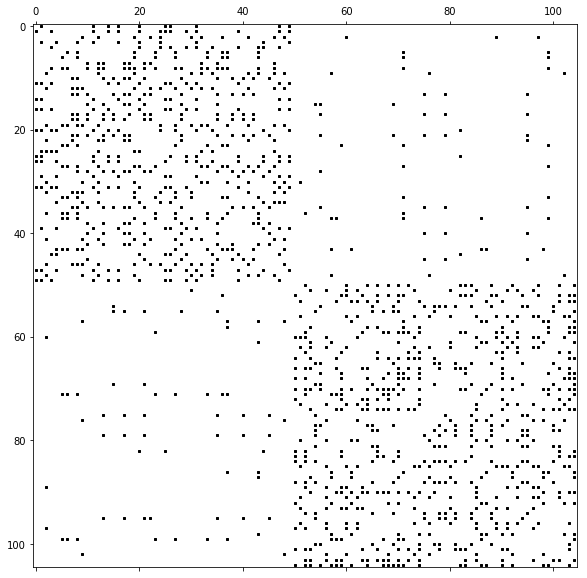

In [21]:
print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
plt.figure(figsize=(10,10))
plt.spy(A, markersize=2, color='black');

In [22]:
L = [graph.laplacian(A, normalized=True) for z in range(2)]

(0, 1.3856405663147908)

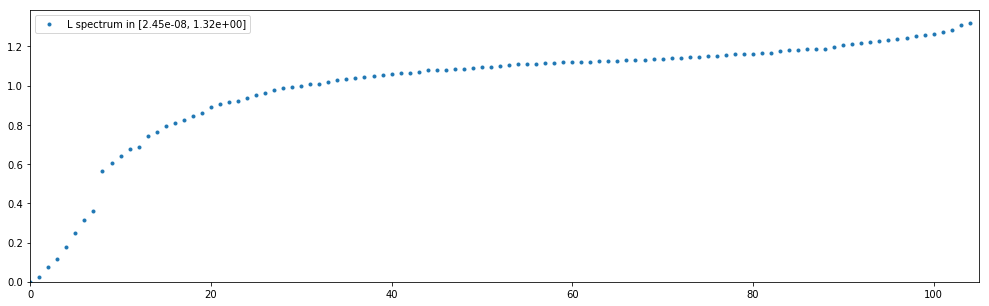

In [23]:
plt.figure(figsize=(17, 5))
lamb, U = np.linalg.eigh(L[0].toarray())
x = range(0, L[0].shape[0])
lb = 'L spectrum in [{:1.2e}, {:1.2e}]'.format(lamb[0], lamb[-1])
plt.plot(x, lamb, '.', label=lb)
plt.legend(loc='best')
plt.xlim(0, L[0].shape[0])
plt.ylim(ymin=0)

## CNN

CNN model was adapted for performing regression instead of classification (see file model_alt.py).

In [24]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 20
params['batch_size']     = 5 # changed
params['eval_frequency'] = 10 # changed

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = A.shape[0]

# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['K']              = [10, 10]  # Polynomial orders.
params['p']              = [1, 1]    # Pooling sizes.
params['M']              = [C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1 # changed
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [25]:
model = models_alt.cgcnn(L, **params)
loss_train, loss_val, t_step = model.fit(X_train, y_train, X_val, y_val)

NN architecture
  input: M_0 = 105
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 105 * 32 / 1 = 3360
    weights: F_0 * F_1 * K_1 = 1 * 32 * 10 = 320
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 105 * 64 / 1 = 6720
    weights: F_1 * F_2 * K_2 = 32 * 64 * 10 = 20480
    biases: F_2 = 64
  layer 3: logits (softmax)
    representation: M_3 = 105
    weights: M_2 * M_3 = 6720 * 105 = 705600
    biases: M_3 = 105
step 10 / 132 (epoch 1.52 / 20):
  learning_rate = 9.50e-04, loss_average = 2.41e+00
  validation loss: 3.69e+00
  time: 1s (wall 1s)
step 20 / 132 (epoch 3.03 / 20):
  learning_rate = 9.03e-04, loss_average = 2.30e+00
  validation loss: 3.20e+00
  time: 2s (wall 1s)
step 30 / 132 (epoch 4.55 / 20):
  learning_rate = 8.15e-04, loss_average = 2.11e+00
  validation loss: 3.06e+00
  time: 2s (wall 1s)
step 40 / 132 (epoch 6.06 / 20):
  learning_rate = 7.74e-04, loss_average = 1.99e+00
  validation loss: 2.99e+00
  time: 3s (wall 2s)
step 50

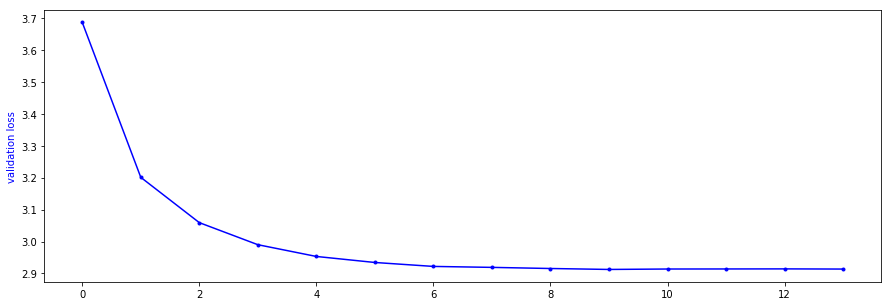

In [43]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(loss_val, 'b.-')
ax1.set_ylabel('validation loss', color='b')
# ax2 = ax1.twinx()
# ax2.plot(loss_train, 'g.-')
# ax2.set_ylabel('training loss', color='g')
plt.show()

In [27]:
res = model.evaluate(X_test, y_test)
print(res[0])

INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-132
loss: 1.91e+00
time: 0s (wall 0s)


In [28]:
Pred_train = model.predict(X_train)
Pred_test = model.predict(X_test)

INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-132
INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-132


In [29]:
from matplotlib.colors import ListedColormap
mycmap = ListedColormap(['white','blue','red'])


Votes color:
- Red: Yes
- Blue: No


Text(0.5,1,'Training truth')

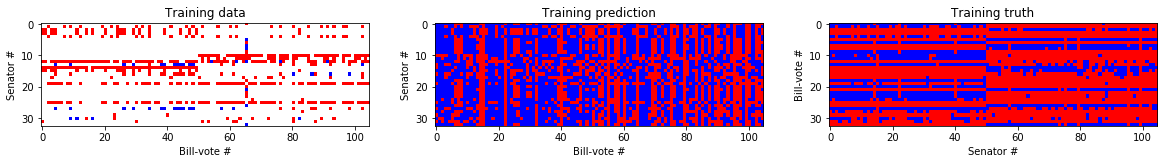

In [30]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Training data')
plt.subplot(1,3,2)
plt.imshow((Pred_train-Pred_train.mean(axis=1)[:,np.newaxis])>0, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Training prediction')
plt.subplot(1,3,3)
plt.imshow(y_train, vmax = 1, vmin=-1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Training truth')

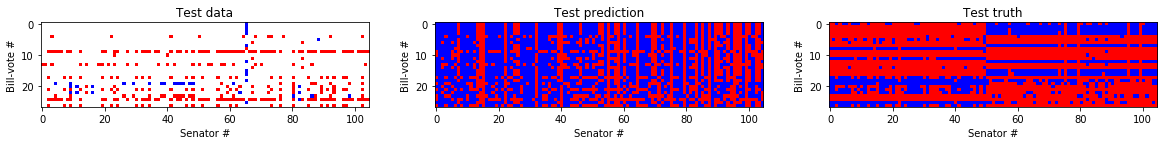

In [44]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test data')
plt.subplot(1,3,2)
plt.imshow(Pred_test>np.mean(Pred_test), vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test prediction')
plt.subplot(1,3,3)
plt.imshow(y_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test truth');

## Estimate graph filter - linear regression

Estimate the polynomial graph filter $f(L) = \sum^K_k \alpha_k L^k$ using least squares:
1. Solve: 
$$\min_{\alpha}\left\Vert Y-\sum^K_{k=0} \alpha_k L^k X\right\Vert^2$$

In [32]:
Laplacian = L[0].todense()

In [33]:
Laplacian.shape

(105, 105)

In [34]:
K = 100  # Filter parameters

In [35]:
tX=[]
for i in range(0, K):
    tX.append(np.array(X_train @ np.linalg.matrix_power(Laplacian, i)))

In [36]:
M=np.zeros((K,K))
Ym = np.zeros(K)
for i in range(K):
    for j in range(K):
        M[i,j] = np.sum(tX[i] * tX[j])
    Ym[i] = np.sum(tX[i] * y_train)

In [37]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [38]:
reg.fit(M, Ym)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [39]:
theta = reg.coef_

Text(0.5,1,'Training truth')

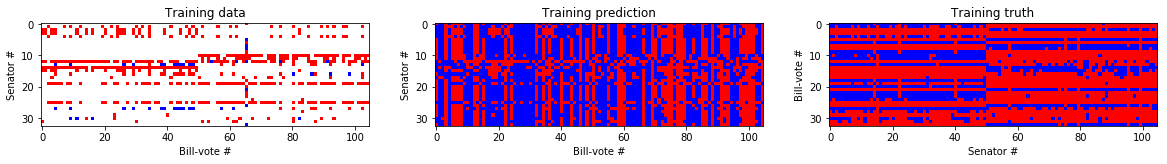

In [40]:
Pred = sum([theta[i]*j for i, j in enumerate(tX)])
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Training data')
plt.subplot(1,3,2)
plt.imshow((Pred-Pred.mean(axis=1)[:,np.newaxis])>0, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Training prediction')
plt.subplot(1,3,3)
plt.imshow(y_train, vmax = 1, vmin=-1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Training truth')